In [20]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# utility functions 
from utils import count_unique_values, show_group_stats_viz

sns.set()

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### leggiamo l'intero LARGE dataset

In [2]:
%%time

# le colonne che saranno caricate in memoria
cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        }

# ora leggo tutto
orig_train = pd.read_csv('train.csv', dtype=dtypes, usecols=cols)
orig_train['click_time'] = pd.to_datetime(orig_train['click_time'])

CPU times: user 1min 28s, sys: 3.6 s, total: 1min 31s
Wall time: 3min


In [12]:
print('Number of record in dataset:', orig_train.shape[0])

Number of record in dataset: 184903890


is_attributed
0    184447044
1       456846
dtype: int64


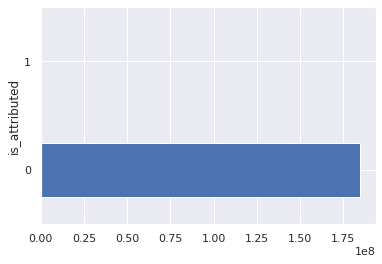

In [21]:
show_group_stats_viz(orig_train, 'is_attributed');

In [4]:
# Alcune statistiche

# analizziamo i valori distinti:
for col in sorted(cols):
    print('Distinct values for', col, ':', orig_train[col].nunique())
    
# statistiche target
stats = orig_train.groupby('is_attributed').count()['ip']

n_pos = stats[1]
n_neg = stats[0]

print()
print('Number of positive samples:', n_pos)
print('Number of negative samples:', n_neg)
print('Anomalies (before resampling) percentage:', round(float(n_pos)*100./float(n_pos + n_neg), 4))

Distinct values for app : 706
Distinct values for channel : 202
Distinct values for click_time : 259620
Distinct values for device : 3475
Distinct values for ip : 277396
Distinct values for is_attributed : 2
Distinct values for os : 800

Number of positive samples: 456846
Number of negative samples: 184447044
Anomalies (before resampling) percentage: 0.2471


In [5]:
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ip             uint32        
 1   app            uint16        
 2   device         uint16        
 3   os             uint16        
 4   channel        uint16        
 5   click_time     datetime64[ns]
 6   is_attributed  uint8         
dtypes: datetime64[ns](1), uint16(4), uint32(1), uint8(1)
memory usage: 3.6 GB


### feature engineering

In [6]:
# adding new features

def add_new_features(df):
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('uint8')
    
    print('group by : ip_app_channel_var_day')
    gp = df[['ip','app', 'channel', 'day']].groupby(by=['ip', 'app', 'channel'])[['day']].var().reset_index().rename(index=str, columns={'day': 'ip_app_channel_var_day'})
    df = df.merge(gp, on=['ip','app', 'channel'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_day_hour_count_chl')
    gp = df[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
    df = df.merge(gp, on=['ip','day','hour'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_count_chl')
    gp = df[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
    df = df.merge(gp, on=['ip','app'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_os_count_chl')
    gp = df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
    df = df.merge(gp, on=['ip','app', 'os'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_day_chl_var_hour')
    gp = df[['ip','day','hour','channel']].groupby(by=['ip','day','channel'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'qty_var'})
    df = df.merge(gp, on=['ip','day','channel'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_os_var_hour')
    gp = df[['ip','app', 'os', 'hour']].groupby(by=['ip', 'app', 'os'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_app_os_var'})
    df = df.merge(gp, on=['ip','app', 'os'], how='left')
    del gp
    gc.collect()
    
    print('group by : ip_app_chl_mean_hour')
    gp = df[['ip','app', 'channel','hour']].groupby(by=['ip', 'app', 'channel'])[['hour']].mean().reset_index().rename(index=str, columns={'hour': 'ip_app_channel_mean_hour'})
    df = df.merge(gp, on=['ip','app', 'channel'], how='left')
    del gp
    gc.collect()
    
    # resetting types (risparmiamo 4 GB)
    df['qty'] = df['qty'].astype('uint16')
    df['ip_app_count'] = df['ip_app_count'].astype('uint16')
    df['ip_app_os_count'] = df['ip_app_os_count'].astype('uint16')

    return df

In [7]:
%%time

orig_train = add_new_features(orig_train)

group by : ip_app_channel_var_day
group by : ip_day_hour_count_chl
group by : ip_app_count_chl
group by : ip_app_os_count_chl
group by : ip_day_chl_var_hour
group by : ip_app_os_var_hour
group by : ip_app_chl_mean_hour
CPU times: user 8min 59s, sys: 38 s, total: 9min 37s
Wall time: 9min 37s


In [8]:
orig_train.tail()

,ip,app,device,os,channel,click_time,is_attributed,hour,day,ip_app_channel_var_day,qty,ip_app_count,ip_app_os_count,qty_var,ip_app_os_var,ip_app_channel_mean_hour
184903885,121312,12,1,10,340,2017-11-09 16:00:00,0,16,9,0.000000,4,491,9,27.766667,26.750000,10.166667
184903886,46894,3,1,19,211,2017-11-09 16:00:00,0,16,9,0.481132,4,1557,375,34.732026,43.638816,9.314815
184903887,320126,1,1,13,274,2017-11-09 16:00:00,0,16,9,NaN,3,17,6,NaN,26.666667,16.000000
184903888,189286,12,1,37,259,2017-11-09 16:00:00,0,16,9,0.885763,1,643,22,27.307776,21.593074,10.882812
184903889,106485,11,1,19,137,2017-11-09 16:00:00,0,16,9,0.244953,1,812,197,22.157178,37.324148,11.263464


In [9]:
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184903890 entries, 0 to 184903889
Data columns (total 16 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ip                        uint32        
 1   app                       uint16        
 2   device                    uint16        
 3   os                        uint16        
 4   channel                   uint16        
 5   click_time                datetime64[ns]
 6   is_attributed             uint8         
 7   hour                      uint8         
 8   day                       uint8         
 9   ip_app_channel_var_day    float64       
 10  qty                       uint16        
 11  ip_app_count              uint16        
 12  ip_app_os_count           uint16        
 13  qty_var                   float64       
 14  ip_app_os_var             float64       
 15  ip_app_channel_mean_hour  float64       
dtypes: datetime64[ns](1), float64(4), uint16(7), uint3

In [10]:
%%time

# save for fatser restart
orig_train.to_feather("train_augmented.fea")

CPU times: user 31.6 s, sys: 8.97 s, total: 40.6 s
Wall time: 12.1 s


In [14]:
%%time

# del orig_train


# per serializzare il risultato della Feature Engineering conviene NOn usare csv ed usare formagti compressi, io ho usato feather
# ma avrei potuto usare Parquet

orig_train = pd.read_feather("train_augmented.fea")

CPU times: user 8.95 s, sys: 7.18 s, total: 16.1 s
Wall time: 3.31 s


In [15]:
orig_train.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,day,ip_app_channel_var_day,qty,ip_app_count,ip_app_os_count,qty_var,ip_app_os_var,ip_app_channel_mean_hour
0,83230,3,1,13,379,2017-11-06 14:32:21,0,14,6,0.914338,1,5427,1326,7.893333,38.855403,8.619632
1,17357,3,1,19,379,2017-11-06 14:33:34,0,14,6,0.745750,1,5025,1380,9.618462,26.386922,8.090909
2,35810,3,1,13,379,2017-11-06 14:34:12,0,14,6,0.690244,1,2012,442,15.600000,34.029284,8.317073
3,45745,14,1,13,478,2017-11-06 14:34:52,0,14,6,0.883721,1,9474,1954,5.947712,39.259411,10.477273
4,161007,3,1,13,379,2017-11-06 14:35:08,0,14,6,0.619048,1,232,80,10.800000,37.221361,11.428571


In [16]:
orig_train.shape

(184903890, 16)

In [17]:
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 16 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ip                        uint32        
 1   app                       uint16        
 2   device                    uint16        
 3   os                        uint16        
 4   channel                   uint16        
 5   click_time                datetime64[ns]
 6   is_attributed             uint8         
 7   hour                      uint8         
 8   day                       uint8         
 9   ip_app_channel_var_day    float64       
 10  qty                       uint16        
 11  ip_app_count              uint16        
 12  ip_app_os_count           uint16        
 13  qty_var                   float64       
 14  ip_app_os_var             float64       
 15  ip_app_channel_mean_hour  float64       
dtypes: datetime64[ns](1), float64(4), uint16(7), uint3